### Goal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt

### TODO: update this path

In [3]:
root = "/Users/michaelmoret/tinyverse/krap/data/12_04_24/olabplex_2nd/single/"

### From here; automatic run

In [4]:
for file in os.listdir(root):
    if file.endswith(".txt"):
        print(file)

20241204$25^EN_IHNY_bleached_CTRL$25^EN_IHNY_bleached_Olaplex*0.01$25^EN_IHNY_bleached_Olaplex*0.03$25^EN_IHNY_bleached_Olaplex*0.05$single.txt


In [5]:
savepath = f"{root}plots/"
os.makedirs(savepath, exist_ok=True)

In [6]:
all_dfs = []
for file in os.listdir(root):
    if file.endswith(".txt"):
        df = pd.read_csv(root + file, sep="\t")
        splitted_name = file.split("$")
        # get the experiments; i.e. not the date
        # not the single or triple
        splitted_name = splitted_name[1:-1]
        # add the experiment name in the dataframe
        all_names = []
        for entries in splitted_name:
            times_name = entries.split("^")
            _times = int(times_name[0])
            _name = times_name[1]
            all_names += [_name] * _times
        df["Name"] = all_names
        # remove nan
        df = df.dropna()
        all_dfs.append(df)
        
# merge df
df_merged = pd.concat(all_dfs)
df_merged.head(5)

,RECORD,MEAN AREA,ESTIMATED_LENGTH(*),GRADIENT(*),EMOD(*)(#),DECRIMPING_WORK,EXTENSION_WORK,START_X(*),START_Y,END_X(*),END_Y,ANALYSIS_WORK,BREAK_STRAIN(*)(#),BREAK_LOAD,TENSILE_STRENGTH,Name
0,1,3455.8,30.60,0.5992,5.305000e+09,2.060000e-07,0.007942,0.2614,20.30,0.8497,51.53,0.000022,51.176,0.6666,192.9,EN_IHNY_bleached_CTRL
1,2,6049.7,30.57,1.1000,5.556000e+09,0.000000e+00,0.012790,0.2617,21.00,0.8505,53.52,0.000041,47.530,1.1700,193.5,EN_IHNY_bleached_CTRL
2,3,4438.2,30.14,0.8011,5.440000e+09,2.306000e-07,0.009222,0.2322,17.02,0.8626,51.95,0.000029,50.796,0.7819,176.2,EN_IHNY_bleached_CTRL
3,4,4199.5,30.26,0.8044,5.796000e+09,2.894000e-07,0.008945,0.2644,19.27,0.8592,54.31,0.000028,46.927,0.8442,201.0,EN_IHNY_bleached_CTRL
4,5,3652.8,30.09,0.6713,5.530000e+09,4.905000e-09,0.008849,0.2326,18.13,0.8308,50.90,0.000023,52.044,0.7736,211.8,EN_IHNY_bleached_CTRL


## Helper Functions

In [7]:
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
import numpy as np

def create_boxplot(df, metric_column, group_column='Name', figsize=(10, 6)):
   """Create a compact boxplot with statistical test and median values"""
   
   # Create plot
   fig, ax = plt.subplots(figsize=figsize)
   
   # Function to remove outliers
   def remove_outliers(data):
       Q1 = np.percentile(data, 25)
       Q3 = np.percentile(data, 75)
       IQR = Q3 - Q1
       lower_bound = Q1 - 1.5 * IQR
       upper_bound = Q3 + 1.5 * IQR
       return data[(data >= lower_bound) & (data <= upper_bound)]
   
   # Get unique base names (before *) and assign colors
   base_names = set([name.split('*')[0] for name in df[group_column].unique()])
   colors = plt.cm.Set3(np.linspace(0, 1, len(base_names)))
   color_dict = dict(zip(base_names, colors))
   
   # Create boxplot without outliers
   bp = df.boxplot(column=metric_column, 
                   by=group_column,
                   ax=ax,
                   grid=False,
                   showfliers=False,
                   medianprops={'color': 'red', 'linewidth': 1.5},
                   boxprops={'color': 'black'},
                   whiskerprops={'color': 'black'},
                   capprops={'color': 'black'},
                   patch_artist=True)
   
   # Color the boxes based on base names
   for i, box in enumerate(bp.patches):
       group_name = df[group_column].unique()[i]
       base_name = group_name.split('*')[0]
       box.set_facecolor(color_dict[base_name])
       box.set_alpha(0.7)
   
   # Remove top and right spines
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   
   # Get unique groups
   group_names = df[group_column].unique()
   
   # Add median values on top of each box
   for i, group in enumerate(group_names):
       median = df[df[group_column] == group][metric_column].median()
       ax.text(i+1, ax.get_ylim()[1]*1.02, f'Median: {median:.1f}', 
               horizontalalignment='center', fontsize=9)
   
   # Perform pairwise Mann-Whitney U tests without outliers
   pairs = list(combinations(group_names, 2))
   
   for group1_name, group2_name in pairs:
       # Get data and remove outliers
       group1_data = df[df[group_column] == group1_name][metric_column]
       group2_data = df[df[group_column] == group2_name][metric_column]
       
       group1_clean = remove_outliers(group1_data)
       group2_clean = remove_outliers(group2_data)
       
       stat, p_value = scipy.stats.mannwhitneyu(group1_clean, group2_clean, alternative='two-sided')
       if p_value < 0.05:  # Only print if statistically significant
           print(f"Statistical significance between {group1_name} and {group2_name}: p = {p_value:.4f}")
   
   # Only axis labels
   plt.suptitle('')
   plt.title('')
   plt.xticks(rotation=45, ha='right')
   plt.xlabel(group_column, fontsize=10)
   plt.ylabel(metric_column.replace('_', ' ').title(), fontsize=10)
   ax.yaxis.grid(True, linestyle='--', alpha=0.3)
   
   plt.tight_layout()
   
   return fig, ax

In [8]:
df_merged.columns

Index(['RECORD', 'MEAN AREA', 'ESTIMATED_LENGTH(*)', 'GRADIENT(*)',
       'EMOD(*)(#)', 'DECRIMPING_WORK', 'EXTENSION_WORK', 'START_X(*)',
       'START_Y', 'END_X(*)', 'END_Y', 'ANALYSIS_WORK', 'BREAK_STRAIN(*)(#)',
       'BREAK_LOAD', 'TENSILE_STRENGTH', 'Name'],
      dtype='object')

Statistical significance between EN_IHNY_bleached_CTRL and EN_IHNY_bleached_Olaplex*0.03: p = 0.0057


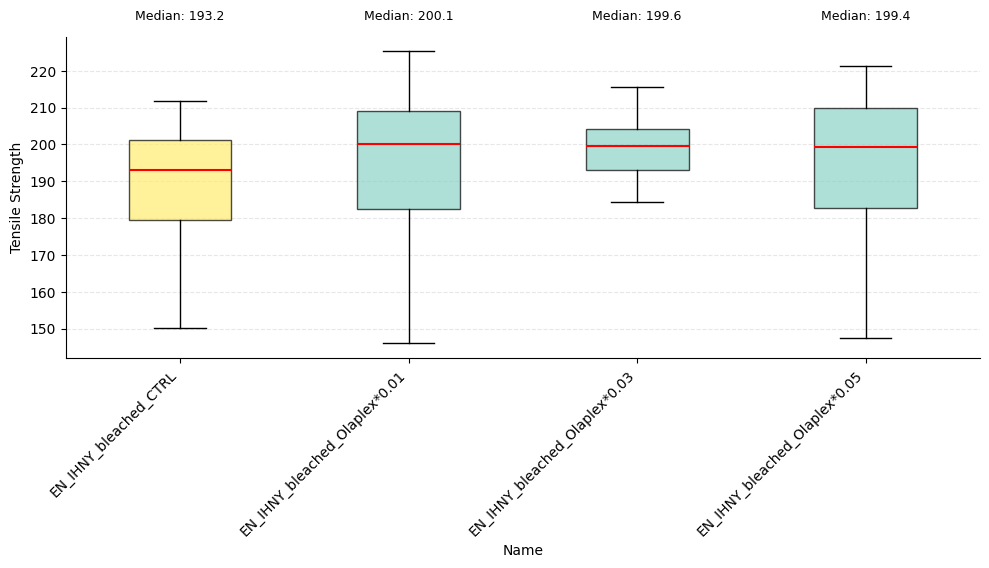

In [9]:
header = 'TENSILE_STRENGTH'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

Statistical significance between EN_IHNY_bleached_Olaplex*0.03 and EN_IHNY_bleached_Olaplex*0.05: p = 0.0361


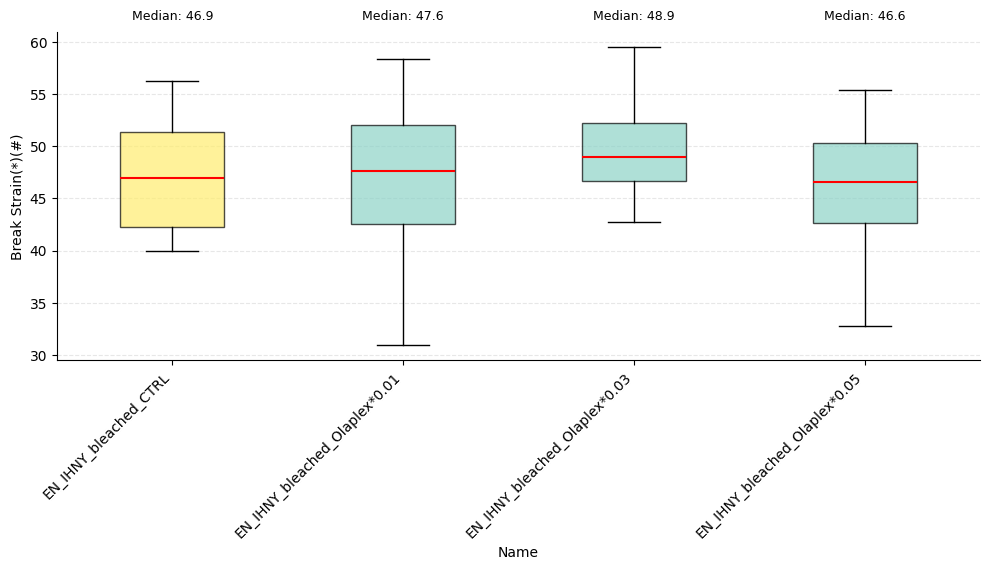

In [10]:
header = 'BREAK_STRAIN(*)(#)'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()

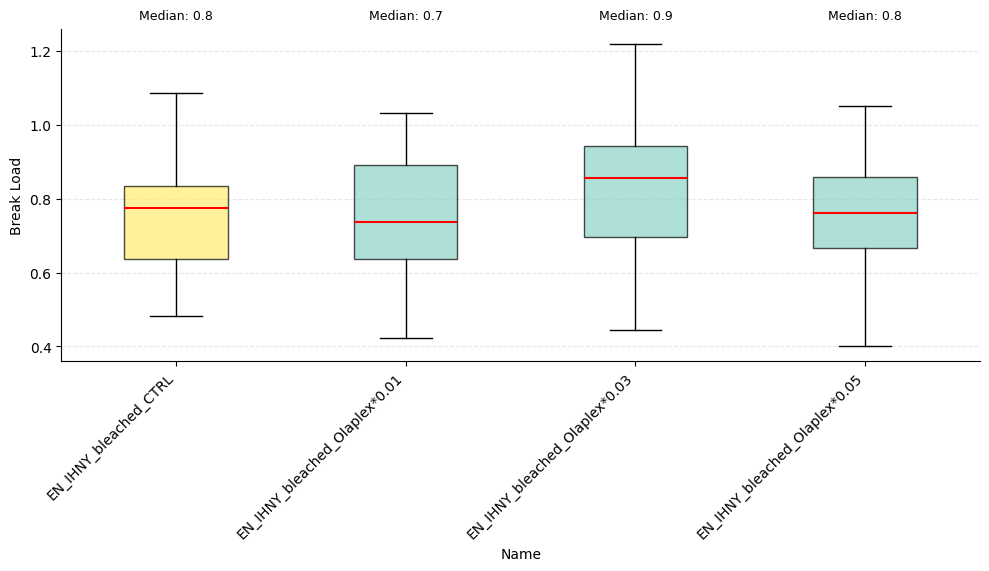

In [11]:
header = 'BREAK_LOAD'
fig, ax = create_boxplot(df_merged, header)
fig.savefig(f"{savepath}{header}.png")
plt.show()